# Download and process OpenMRG dataset

This notebook 
* downloads the dataset [OpenMRG (Andersson et al. 2022)](https://doi.org/10.5194/essd-14-5411-2022)
* crops to shorter periods 
* transforms into a common data structure
* shows some statisitcs and comparisons of the CML and reference data
* does some basic CML processing
* and saves to NetCDF

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import opensense_data_downloader_and_transformer as oddt
import pycomlink as pycml
import glob as glob
import pandas as pd
import poligrain as plg
import pyproj
import gzip, tarfile
import zipfile
import shutil
import os

## Download and transform OpenMRG dataset

Download OpenMRG dataset with code from [OpnSense sandbox](link) and transform to the data format standards given in [Fencl et al. 2023](https://open-research-europe.ec.europa.eu/articles/3-169).

In [2]:
# function from OpenSense sandbox 
oddt.download_andersson_2022_OpenMRG(
    local_path="data/andersson_2022_OpenMRG/", print_output=True
);

File already exists at desired location data/andersson_2022_OpenMRG/OpenMRG.zip
Not downloading!


In [3]:
# function from OpenSense sandbox
ds_cmls = oddt.transform_andersson_2022_OpenMRG(
    fn="data/andersson_2022_OpenMRG/OpenMRG.zip",
    path_to_extract_to="data/andersson_2022_OpenMRG/",
    time_start_end=(
        "2015-07-22",
        "2015-07-29",
    ),  
    restructure_data=True,
)

t_start = ds_cmls.time.min().data
t_end = ds_cmls.time.max().data

/Users/chwala-c/code/opensense_example_data/OpenMRG/notebooks/opensense_data_downloader_and_transformer.py:303: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink':df_metadata.index})


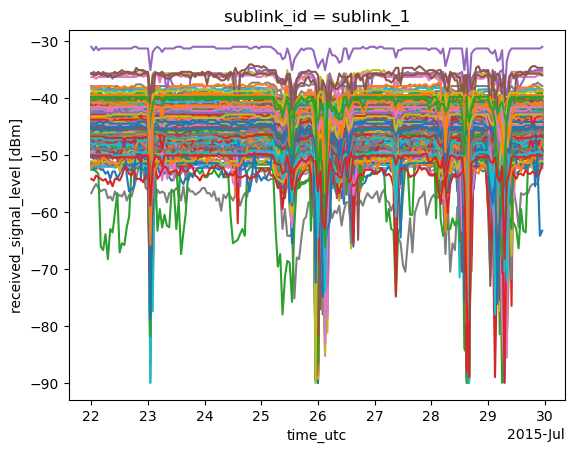

In [4]:
ds_cmls.rsl.isel(sublink_id=0).resample(time='1h').min().plot.line(x='time', add_legend=False);

## Load gauge data and write selected period to NetCDF

In [5]:
df_gauges_city = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

df_gauges_city_metadata = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-metadata.csv",
    index_col=0,
)

ds_gauges_city = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["id", "time"], df_gauges_city.T),
    ),
    coords=dict(
        id=df_gauges_city_metadata.index.values,
        time=df_gauges_city.index.values,
        lon=(["id"], df_gauges_city_metadata.Longitude_DecDeg),
        lat=(["id"], df_gauges_city_metadata.Latitude_DecDeg),
        location=(["id"], df_gauges_city_metadata.Location),
        type=(["id"], df_gauges_city_metadata.Type),
        quantization=(["id"], df_gauges_city_metadata["Resolution (mm)"]),
    ),
)
ds_gauges_city

<xarray.Dataset> Size: 12MB
Dimensions:          (id: 10, time: 132480)
Coordinates:
  * id               (id) object 80B 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'
  * time             (time) datetime64[ns] 1MB 2015-06-01T00:01:00 ... 2015-0...
    lon              (id) float64 80B 11.94 12.04 12.07 ... 11.99 11.97 11.94
    lat              (id) float64 80B 57.65 57.72 57.75 ... 57.71 57.71 57.63
    location         (id) object 80B 'Järnbrottsmotet' ... 'Askim Ögärdesv'
    type             (id) object 80B 'Weighing' 'Weighing' ... 'Tipping-bucket'
    quantization     (id) float64 80B 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2
Data variables:
    rainfall_amount  (id, time) float64 11MB 0.1 0.0 0.1 0.0 ... 0.0 0.2 0.0 0.0

In [6]:
df_gauge_smhi = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/smhi/GbgA-71420-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

ds_gauges_smhi = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["id", "time"], [df_gauge_smhi.Pvol_mm.values]),
    ),
    coords=dict(
        id=["SMHI"],
        time=df_gauge_smhi.index.values,
        lon=(["id"], [11.9924]),
        lat=(["id"], [57.7156]),
        location=(["id"], ["Goeteburg A"]),
        type=(["id"], ["15 min rainfall sum"]),
        quantization=(["id"], [0.1]),
    ),
)

In [7]:
ds_gauges_city = ds_gauges_city.sel(time=slice(t_start, t_end))
ds_gauges_smhi = ds_gauges_smhi.sel(time=slice(t_start, t_end))

In [8]:
ds_gauges_city.to_netcdf('../openmrg_municp_gauge_8d.nc', encoding={'rainfall_amount': {'zlib': True}})
ds_gauges_smhi.to_netcdf('../openmrg_smhi_gauge_8d.nc', encoding={'rainfall_amount':  {'zlib': True}})

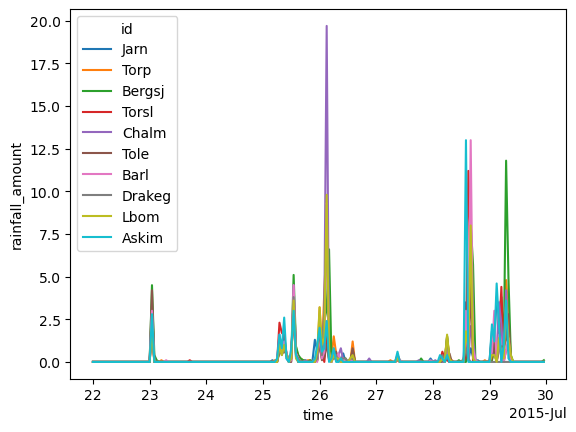

In [9]:
ds_gauges_city.rainfall_amount.resample(time='1h').sum().plot.line(x='time');

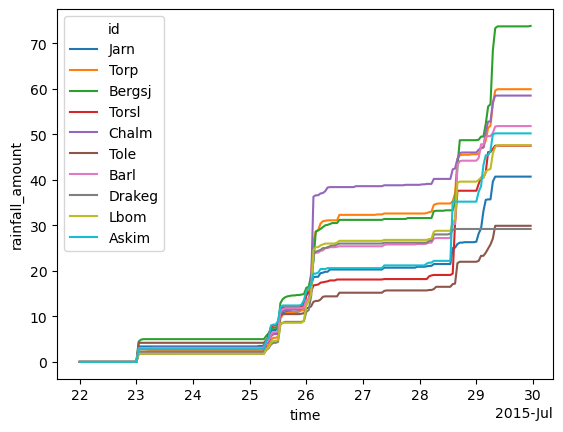

In [10]:
ds_gauges_city.rainfall_amount.resample(time='1h').sum().cumsum(dim='time').plot.line(x='time');

## Load radar data, calculate rain rates and write to NetCDF

In [11]:
ds_radar = xr.open_dataset(
    "data/andersson_2022_OpenMRG/radar/radar.nc"
)
ds_radar = ds_radar.rename_vars({'data': 'dBZ'})
# get rain rates from radar reflecitivity using values from Andersson et al (2022)
ds_radar["R"] = (10 ** (ds_radar.dBZ / 10) / 200) ** (1/1.5)
ds_radar.R.attrs = {
    'units': 'mm/h', 
    'long_name': 'rain rate', 
    'comment': 'calculated from provided dBZ in original data using Z = 200 * R ** 1.5',
}

#add lon lat grid
x_grid, y_grid = np.meshgrid(ds_radar.x.values, ds_radar.y.values)
transformer = pyproj.Transformer.from_crs(
    "+proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90",
    "EPSG:4326",
    always_xy=True,
)
lon_grid, lat_grid = transformer.transform(xx=x_grid, yy=y_grid)

ds_radar.coords["lon"] = (("y", "x"), lon_grid)
ds_radar.coords["lat"] = (("y", "x"), lat_grid)

In [12]:
ds_radar = ds_radar.sel(time=slice(t_start, t_end))

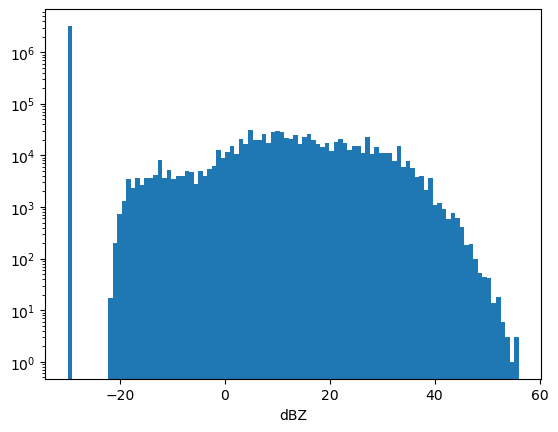

In [13]:
ds_radar.dBZ.plot.hist(bins=100, yscale='log');

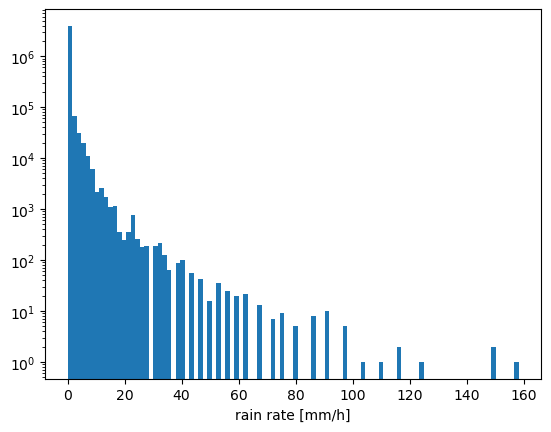

In [14]:
ds_radar.R.plot.hist(bins=100, yscale='log');

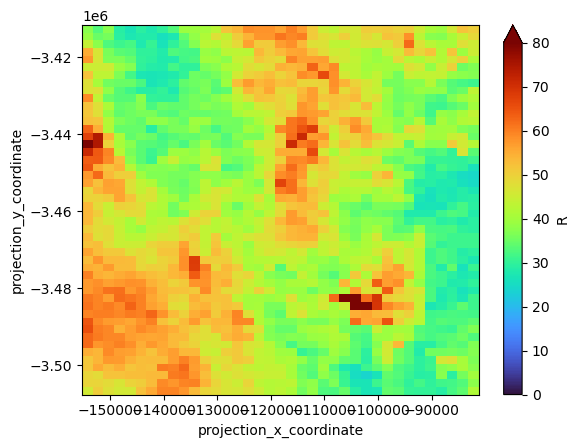

In [15]:
ds_radar.R.resample(time='1h').mean().sum(dim='time').plot(vmin=0, vmax=80, cmap='turbo')

In [16]:
ds_radar.R.encoding = {'zlib': True, 'complevel': 4, 'dtype': 'int', 'scale_factor': 0.01, '_FillValue': -9999}
ds_radar.drop_vars('dBZ').to_netcdf('../openmrg_rad_8d.nc')

## Process CML data and write to NetCDF

In [17]:
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

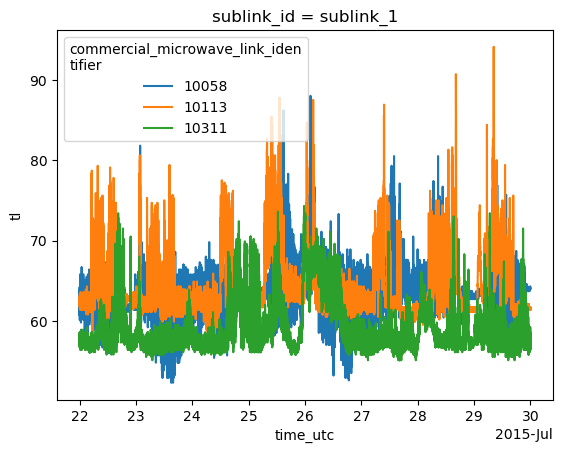

In [18]:
ds_cmls.where(qc_diurnalcicle, drop=True).isel(sublink_id=0).tl.plot.line(x='time');

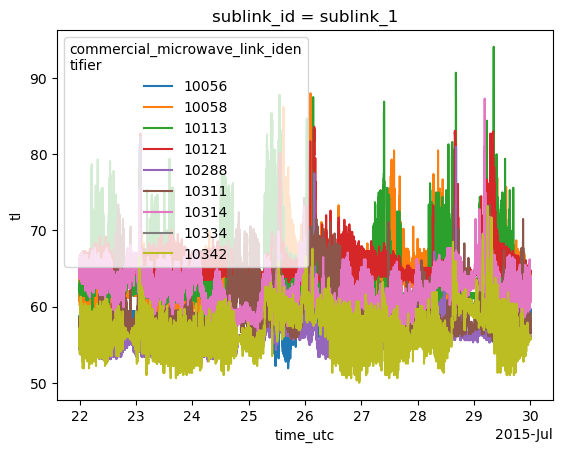

In [19]:
ds_cmls.where(qc_noisyperiods, drop=True).isel(sublink_id=0).tl.plot.line(x='time');

In [20]:
ds_cmls

<xarray.Dataset> Size: 604MB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates:
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 3kB 11.99 11.97 11.98 ... 12.14 11.97 11.98
    frequency     (sublink_id, cml_id) float64 6kB 2.821e+04 ... 2.926e+04
    polarization  (sublink_id, cml_id) <U1 3kB 'v' 'v' 'v' 'v' ... 'v' 'v' 'v'
    length        (cml_id) float64 3kB 691.4 614.6 323.7 ... 4.806e+03 1.412e+03
Data variables:
    tsl           (time, sublink_id, cml_id) float32 201MB 1.0 0.0 ... 16.0 0.0
    rsl           (time, sublink_id, cml_id) float32 201MB -46.0 -41.0 ... -49.2
    tl            (time, sublink_id, cml_id) float32 201MB 47.0 41.0 ... 49.2
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [74]:
# get radar along CMLs
grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar.R,
    ds_line_data=ds_cmls,
)

da_radar_along_cmls = grid_at_lines(ds_radar.R)
da_radar_along_cmls


# calculate wet periods
#ds_cmls['roll_std_threshold'] = 1.1 * ds_cmls['tl'].rolling(time=60, center=True).std().quantile(0.85, dim='time')
#ds_cmls['wet'] = ds_cmls.tl.rolling(time=60, center=True).std() > ds_cmls.roll_std_threshold
#ds_cmls['wet'] =    ds_cmls.tl.rolling(time=60).std() > 0.4
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

# calculate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)    

# calculate wet antenna effect
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  
    d=0.15, 
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  
    f_GHz=ds_cmls.frequency / 1000,  
    pol=ds_cmls.polarization,
)
ds_cmls["R"].data[ds_cmls.R < 0.01] = 0

### Do some quick analysis of processed CML rain rates

In [75]:
# currently not used for wet-dry
#ds_cmls.roll_std_threshold.plot.hist(bins=100);

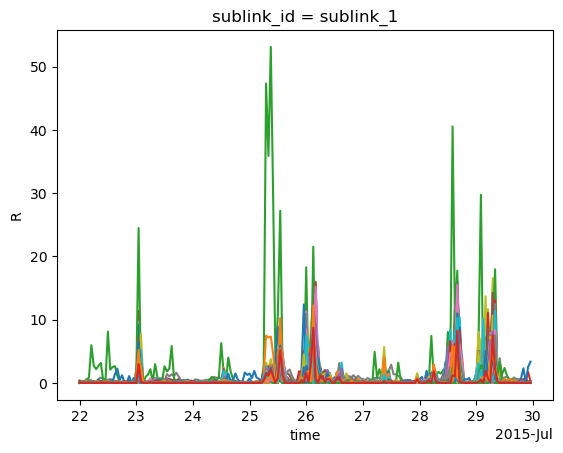

In [76]:
ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().plot.line(x='time', add_legend=False);

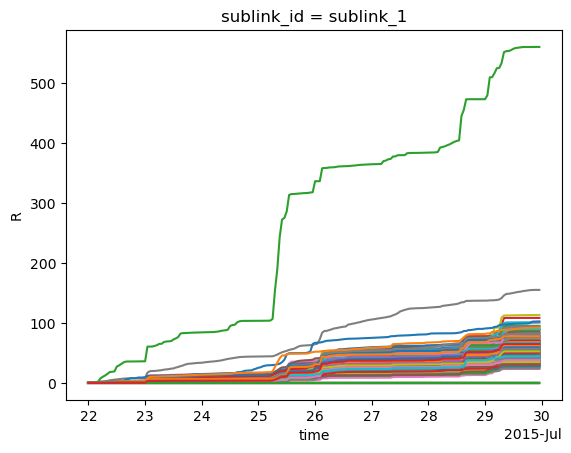

In [77]:
ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().cumsum(dim='time').plot.line(x='time', add_legend=False);

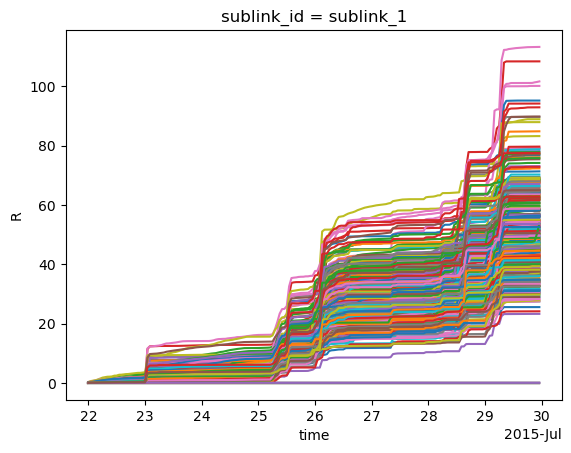

In [78]:
(
    ds_cmls
    .where(~qc_noisyperiods, drop=True)
    .isel(sublink_id=0)
    .R
    .resample(time='1h').mean()
    .cumsum(dim='time')
    .plot.line(x='time', add_legend=False)
);

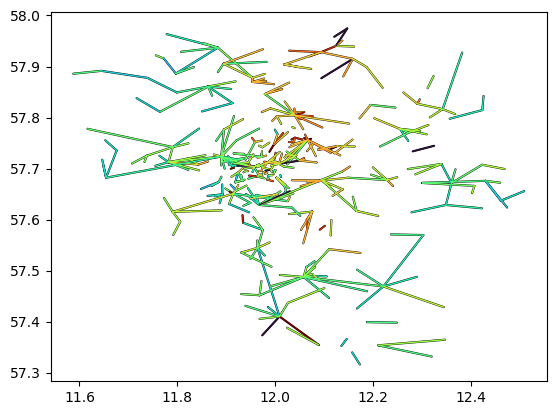

In [79]:
plg.plot_map.plot_lines(ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'), vmin=0, vmax=100)

<Axes: xlabel='lon', ylabel='lat'>

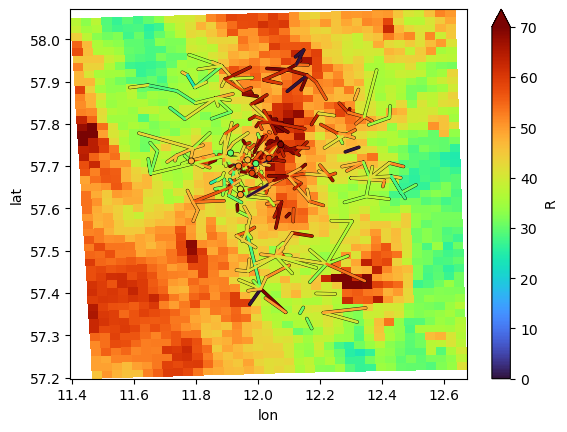

In [80]:
plg.plot_map.plot_plg(
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'),
    da_grid=ds_radar.R.resample(time='1h').mean().sum(dim='time'),
    da_gauges=ds_gauges_city.rainfall_amount.sum(dim='time'),
    vmin=0,
    vmax=70,
)

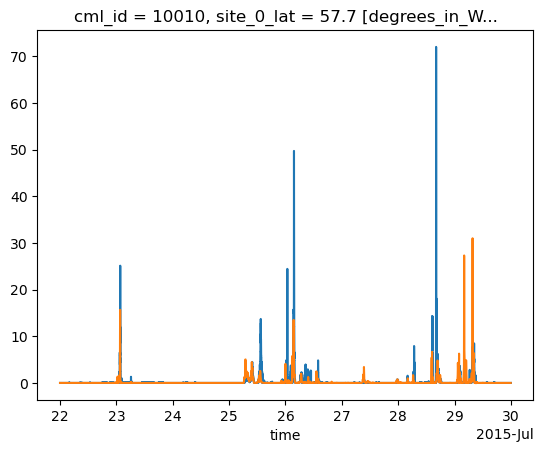

In [81]:
cml_id = 10010

ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.plot()
da_radar_along_cmls.sel(cml_id=cml_id).plot()

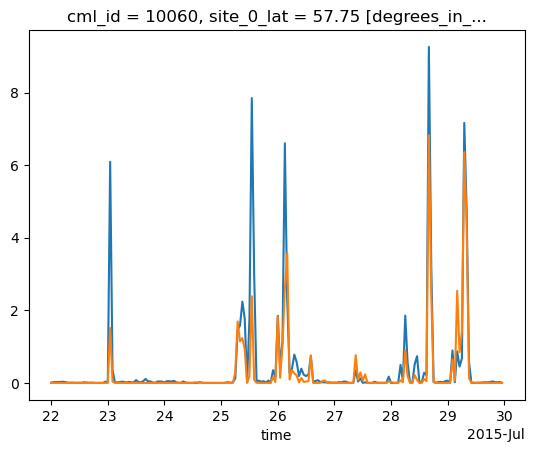

In [82]:
cml_id = 10060

ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.resample(time='1h').mean().plot()
da_radar_along_cmls.sel(cml_id=cml_id).resample(time='1h').mean().plot()

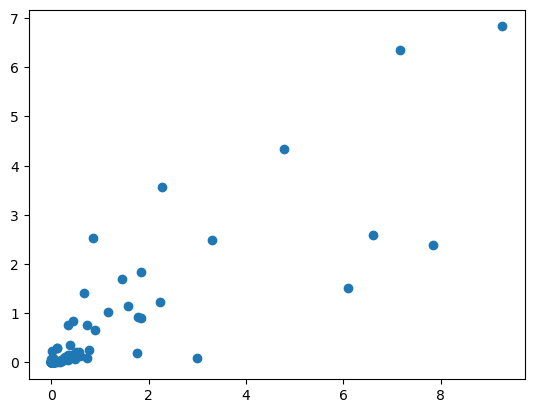

In [83]:
import matplotlib.pyplot as plt
plt.scatter(
    ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.resample(time='1h').mean(),
    da_radar_along_cmls.sel(cml_id=cml_id).resample(time='1h').mean(),
)

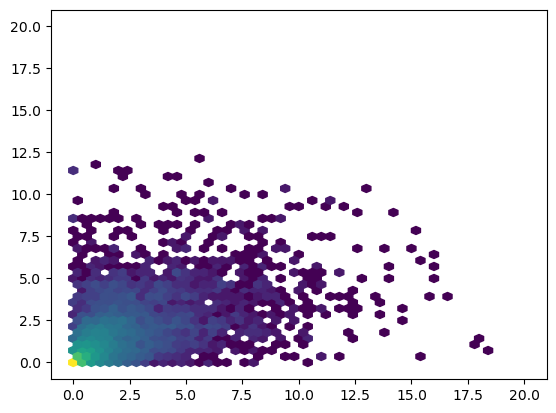

In [84]:
import matplotlib.pyplot as plt
plt.hexbin(
    ds_cmls.isel(sublink_id=0).R.transpose().resample(time='1h').mean().data.flatten(),
    da_radar_along_cmls.resample(time='1h').mean().data.flatten(),
    gridsize=50,
    bins='log',
    extent=[0, 20, 0, 20],
)

(0.0, 100.0)

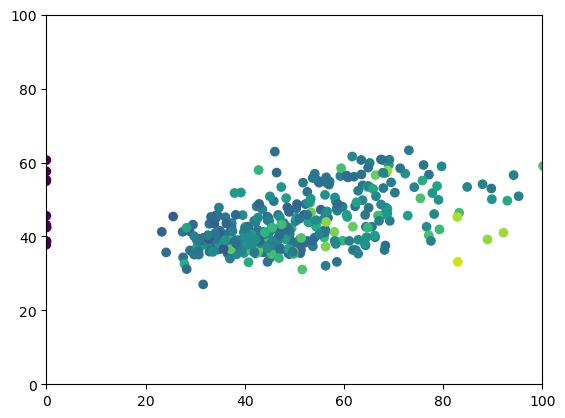

In [85]:
import matplotlib.pyplot as plt
plt.scatter(
    ds_cmls.isel(sublink_id=0).R.transpose().resample(time='1h').mean().sum(dim='time').data,
    da_radar_along_cmls.resample(time='1h').mean().sum(dim='time').data,
    c=(ds_cmls.isel(sublink_id=0).R > 0.1).sum(dim='time'),
)
plt.xlim(0, 100)
plt.ylim(0, 100)

## Write CML NetCDF

In [104]:
ds_cmls.drop_vars(['tl', 'wet', 'baseline', 'A_obs', 'waa', 'A']).to_netcdf(
    '../openmrg_cml_8d.nc', 
    encoding={
        'R': {'zlib': True, 'complevel': 4, 'dtype': 'int32', 'scale_factor': 0.01, '_FillValue': -9999},
        'tsl': {'zlib': True, 'complevel': 4, 'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -999},
        'rsl': {'zlib': True, 'complevel': 4, 'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -999}
    },
)

## 1.2 Download OpenRainER dataset and prepare files with month with liqiud rain only

In [ ]:
# storing to external datasource as this is big due to the radar ref
oddt.download_data_file(
    url="https://zenodo.org/api/records/14731404/files-archive",
    local_path="/bg/data/CML/data/other_data/OpenRainER/", 
    local_file_name='files-archive.zip', print_output=True
)

File already exists at desired location /bg/data/CML/data/other_data/OpenRainER/files-archive.zip
Not downloading!


In [ ]:
dir = '/bg/data/CML/data/other_data/OpenRainER/'

In [ ]:
# unzip files
with zipfile.ZipFile(dir+'files-archive.zip') as zfile:
    zfile.extractall(dir)

In [ ]:
#untar dowloaded files
for tar_filename in os.listdir(dir):
    if tar_filename.endswith('.tar'):
        tar_path = os.path.join(dir, tar_filename)
        
        # Estrazione del file .tar
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(dir)  # Estrai tutto nella stessa directory

C:\Users\Utente\AppData\Local\Temp\ipykernel_16616\51972639.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(dir)  # Estrai tutto nella stessa directory


In [ ]:
# unzip through all files in the directory
for filename in os.listdir(dir):
    # Check if the file has a .gz extension | select only 2 month
    if (filename.endswith('.gz')) & (('202207' in filename) | ('202208' in filename)) :
        gz_path = os.path.join(dir, filename)
        unzipped_path = os.path.join(dir, filename[:-3])  # Remove the .gz extension
        
        # Unzip the file
        with gzip.open(gz_path, 'rb') as f_in:
            with open(unzipped_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        # Delete the original .gz file 
        os.remove(gz_path)

In [ ]:
# menaging AWS

In [ ]:
fns = sorted(glob.glob(dir+"/AWS_20220[7-8]*nc"))

In [ ]:
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.id.values))
common_ids = list(set.intersection(*ids))

rainfall=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    tmp = tmp.sel(id=common_ids)
    rainfall.append(tmp.rainfall_amount.load())


100%|██████████| 2/2 [00:00<00:00, 59.38it/s]


In [ ]:
ds_rainfall = xr.concat(rainfall,dim='time')
ds_rainfall.to_netcdf(dir+"AWS_rainfall.nc")

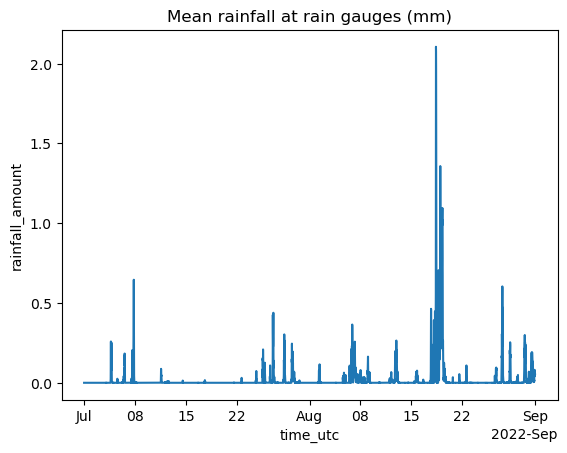

In [ ]:
ds_rainfall.mean(dim='id').plot()
plt.title('Mean rainfall at rain gauges (mm)');

In [ ]:
ds_rainfall.to_netcdf('data/covi_2024_OpenRainER/AWS_rainfall.nc')

#### Merge cmls to one dataset

In [ ]:
fns = sorted(glob.glob(dir+"CML_20220[7-8]*"))
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.cml_id.values))
common_ids = list(set.intersection(*ids))

cmls=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn) 
    tmp = tmp.sel(cml_id=common_ids)
    cmls.append(tmp.load())


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


In [ ]:
ds_cmls = xr.concat(cmls,dim='time')

In [ ]:
#ds_cmls['frequency'] = ds_cmls['frequency'].isel(time=1).drop_vars('time')
#ds_cmls['polarization'] = ds_cmls['polarization'].isel(time=1).drop_vars('time')

In [ ]:
ds_cmls.nbytes/1e9

0.431608248

In [ ]:
ds_cmls.to_netcdf("data/covi_2024_OpenRainER/OpenRainER_cmls.nc")

#### Extracting radar along CML path for each month
from raw files again as its more meory efficient..

In [ ]:
dir = '/bg/data/CML/data/other_data/OpenRainER/'

fns_cml = glob.glob(dir+"/CML_20220[7-8]*")
fns_radar = glob.glob(dir+"/RADadj_20220[7-8]*")

In [ ]:
len(fns_cml) == len(fns_radar)

True

In [ ]:
fns = sorted(glob.glob("/bg/data/CML/data/other_data/OpenRainER/CML_20220[7-8]*"))
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.cml_id.values))
common_ids = list(set.intersection(*ids))

100%|██████████| 2/2 [00:00<00:00, 53.58it/s]


In [ ]:
list_radar_along_cmls=[]
list_radar=[]
count=[]
for i in tqdm(range(len(fns_cml))):
    ds_cml = xr.open_dataset(fns_cml[i]).sel(cml_id=common_ids)
    ds_radar = xr.open_dataset(fns_radar[i])
    # remove unnecessary cords and variables
    ds_radar = ds_radar.drop_vars(['geo_dim','mesh_dim','mosaic'])
    #add lon lat grid
    lon_grid, lat_grid = np.meshgrid(ds_radar.lon.values, ds_radar.lat.values)
    count.append(len(ds_radar.time))
    ds_radar.coords["lon_grid"] = (("lat", "lon"), lon_grid)
    ds_radar.coords["lat_grid"] = (("lat", "lon"), lat_grid)

    list_radar.append(ds_radar)

    # calculate intersection weights
    da_intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
        x1_line=ds_cml.site_0_lon.values,
        y1_line=ds_cml.site_0_lat.values,
        x2_line=ds_cml.site_1_lon.values,
        y2_line=ds_cml.site_1_lat.values,
        cml_id=ds_cml.cml_id.values,
        x_grid=ds_radar.lon_grid.values,
        y_grid=ds_radar.lat_grid.values,
        grid_point_location='center',
    )
    # calculate rainfall along intersectons
    list_radar_along_cmls.append(plg.spatial.get_grid_time_series_at_intersections(
        grid_data=ds_radar.rainfall_amount,
        intersect_weights=da_intersect_weights,
    ))
    

100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


In [ ]:
ds_radar = xr.concat(list_radar,dim='time')
ds_radalong = xr.concat(list_radar_along_cmls,dim='time').to_dataset(name='rainfall_amount')

In [ ]:
# fill in missing time steps
ds_radar = ds_radar.reindex({'time':pd.date_range(ds_radar.time.min().values,ds_radar.time.max().values,freq='15min')})
ds_radalong = ds_radalong.reindex({'time':pd.date_range(ds_radalong.time.min().values,ds_radalong.time.max().values,freq='15min')})

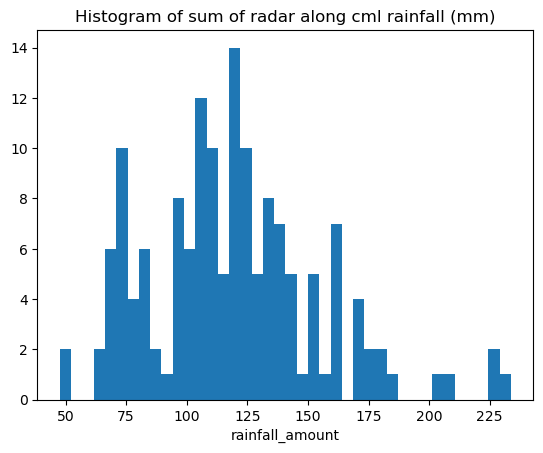

In [ ]:
ds_radalong.rainfall_amount.sum(dim='time').plot.hist(bins=40)
plt.title('Histogram of sum of radar along cml rainfall (mm)');

In [ ]:
# saving both radar and radar_along_cml
ds_radar.to_netcdf("data/covi_2024_OpenRainER/openrainer_radar.nc")
ds_radalong.to_netcdf("data/covi_2024_OpenRainER/RADadj_along_cml.nc")

#### Prepare data for analysis


In [ ]:
ds_gauges=xr.open_dataset("data/covi_2024_OpenRainER/AWS_rainfall.nc").rainfall_amount.load()
ds_gauges=ds_gauges.where(ds_gauges.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

In [ ]:
ds_cml=xr.open_dataset("data/covi_2024_OpenRainER/OpenRainER_cmls.nc").load()
ds_cml=ds_cml.where(ds_cml.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

In [ ]:
ds_radar_along=xr.open_dataset("data/covi_2024_OpenRainER/RADadj_along_cml.nc").load()
ds_radar_along=ds_radar_along.where(ds_radar_along.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

#### Calculate distance between rain gauges and CMLs using [`poligrain`](https://poligrain.readthedocs.io/en/latest/index.html)

In [ ]:
# Project coordinates for rain gauges
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.longitude, ds_gauges.latitude, "EPSG:25832"
)

# Project coordinates for CMLs
(
    ds_cml.coords["site_0_x"],
    ds_cml.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cml.site_0_lon, ds_cml.site_0_lat, "EPSG:25832"
)
(
    ds_cml.coords["site_1_x"],
    ds_cml.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cml.site_1_lon, ds_cml.site_1_lat, "EPSG:25832"
)

In [ ]:
max_distance = 2000  # in meters due to the projection EPSG:25832
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cml, ds_gauges, max_distance=max_distance, n_closest=1
)

In [ ]:
# remove all cml - gauge pairs that are not within 2 km
closest_neigbors = closest_neigbors.where(closest_neigbors.neighbor_id != None,drop=True)

####  Perpare reference data

In [ ]:
# getting the rain gauge time series from the nearest rain gauge for each CML (within 2 km)
reference_15min = xr.full_like(ds_cml.rsl, fill_value=np.nan).resample(time='15min').first().where(ds_gauges.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

In [ ]:
for cmlid in tqdm(closest_neigbors.cml_id):
    tmp_ga_rain = (np.repeat(
        ds_gauges.sel(time=reference_15min.time).sel(id=closest_neigbors.sel(cml_id=cmlid).neighbor_id.values).values[:, np.newaxis],
        2,
        axis=1,))
    reference_15min.loc[dict(cml_id=cmlid)] = tmp_ga_rain[0]

reference_15min = reference_15min.to_dataset(name='rain_gauge_rainfall')

100%|██████████| 88/88 [00:00<00:00, 89.24it/s]


In [ ]:
# sort by cml_id before combining into one dataset
reference_15min = reference_15min.sortby(reference_15min.cml_id)
ds_radar_along =  ds_radar_along.sortby(ds_radar_along.cml_id)

In [ ]:
# add radar_along_cml to reference dataset
reference_15min['radar_along_cml'] = xr.full_like(reference_15min.rain_gauge_rainfall,fill_value=np.nan)

reference_15min['radar_along_cml'].loc[dict(sublink_id='channel1')]=ds_radar_along.rainfall_amount.T
reference_15min['radar_along_cml'].loc[dict(sublink_id='channel2')]=ds_radar_along.rainfall_amount.T

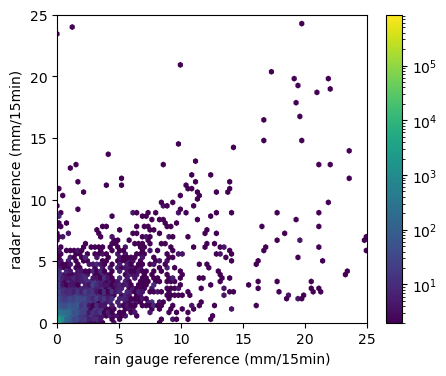

In [ ]:
plt.subplots(figsize=(5,4))
plt.hexbin(
    reference_15min.rain_gauge_rainfall.values.flatten(),
    reference_15min.radar_along_cml.values.flatten(),
    mincnt=1,bins='log')
plt.xlim(0,25)
plt.ylim(0,25)
plt.xlabel('rain gauge reference (mm/15min)')
plt.ylabel('radar reference (mm/15min)')
plt.colorbar();

In [ ]:
dddd
reference_15min.to_netcdf('data/covi_2024_OpenRainER/radar_gauge_15min_reference.nc')